In [ ]:
# standard libraries
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import cv2
import gc
from PIL import Image
import requests
from io import BytesIO

# tensorflow/keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tqdm.keras import TqdmCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load & View Images

In [ ]:
# load images
IMG_SIZE=160
BATCH_SIZE=32
FILE_PATH = "/content/drive/MyDrive/Main dataset"
TEST_PATH = "/content/drive/MyDrive/Cotton Leaf Disease/test"
CLASSES = os.listdir(FILE_PATH)

# read from directory
image_data = image_dataset_from_directory(
    FILE_PATH,
    label_mode='int',
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest',
    labels='inferred',
    shuffle=True,
    class_names = CLASSES)

test_data = image_dataset_from_directory(
    TEST_PATH,
    label_mode='int',
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest',
    labels='inferred',
    shuffle=True,
    class_names = CLASSES)


Found 3591 files belonging to 6 classes.
Found 30 files belonging to 6 classes.


In [ ]:
CLASSES

['Army worm',
 'Healthy',
 'Bacterial Blight',
 'Aphids',
 'Powdery Mildew',
 'Target spot']

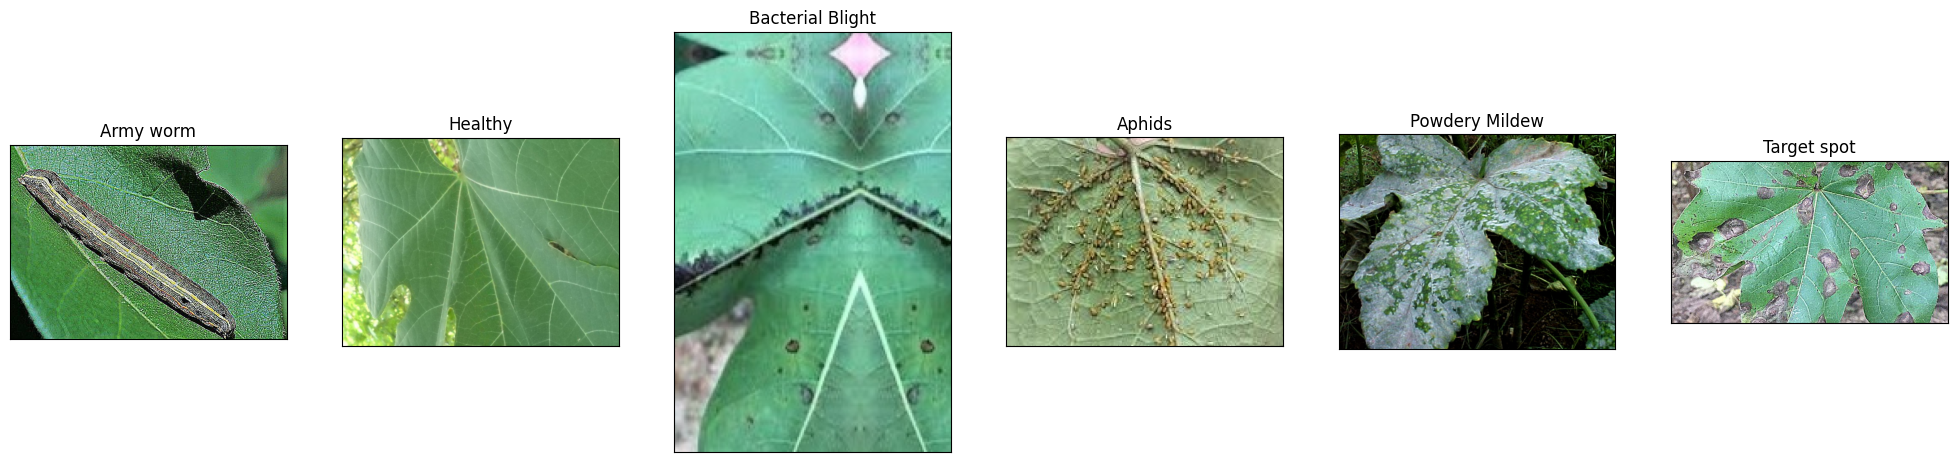

In [ ]:
# generating a list with 1 random image from each class
random_images = []
for i in enumerate(CLASSES):
    random_images.append(random.choice(glob.glob(os.path.join(FILE_PATH,CLASSES[i[0]]+'/*'))))

# showing each image in seperate column
n_cols = len(CLASSES)

# plot the images
plt.figure(figsize=(25, 10))
for c,r in zip(range(n_cols),random_images):
    ax = plt.subplot(1, n_cols, c + 1)
    ax.title.set_text(r.split('/')[5])
    image = cv2.imread(r)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
random_images

['/content/drive/MyDrive/Main dataset/Army worm/pil_constract_2.jpg',
 '/content/drive/MyDrive/Main dataset/Healthy/translation_40.jpg',
 '/content/drive/MyDrive/Main dataset/Bacterial Blight/crop_9.jpg',
 '/content/drive/MyDrive/Main dataset/Aphids/flip_horizontal_7.jpg',
 '/content/drive/MyDrive/Main dataset/Powdery Mildew/pil_sharpness_13.jpg',
 '/content/drive/MyDrive/Main dataset/Target spot/flip_24.jpg']

# Data Preprocessing

In [ ]:
#data pipeline
#def convert_to_float(image,label):
#    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#    return image,label

AUTOTUNE = tf.data.experimental.AUTOTUNE

# configure training dataset
'''due to very few images per class, we will be using the entire image data for training'''
# ds_train = image_data.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
ds_train = image_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# data augmentation
'''
Since the dataset is small, as a good practice we'll introduce sample diversity by applying random transformations to the training images.
Here we're applying horizontal flip , rotation, contrast & zoom.
'''
data_augmentation = keras.Sequential([
  layers.RandomFlip('horizontal')
  ,layers.RandomRotation(0.2)
  ,layers.RandomContrast(0.2)
  ,layers.RandomZoom(0.5,0.2)
])

In [ ]:
# rescale pixel values
'''the base model (MobileNetV2) expects pixel values in [-1,1]'''
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
rescale = layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# create base model - MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# model's feature extractor shape conversion
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(f"{IMG_SHAPE} converted to {feature_batch.shape}")

(160, 160, 3) converted to (32, 5, 5, 1280)


# Build Model

In [ ]:
# feature extraction
'''it is imperative to freeze the layers from being updated during training'''
base_model.trainable = False

In [ ]:
# classification head
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(f"Feature Batch Shape: {feature_batch_average.shape} ")

# prediction layer
prediction_layer =  layers.Dense(len(CLASSES),activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(f"Prediction Batch Shape: {prediction_batch.shape}")

Feature Batch Shape: (32, 1280) 
Prediction Batch Shape: (32, 6)


In [ ]:
# build model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

# Compile & Train Model

In [ ]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# training the model
epochs = 50
earlyStopping = keras.callbacks.EarlyStopping(monitor='loss',patience=5,verbose=0)
hist = model.fit(ds_train
          , epochs = epochs
          , batch_size=BATCH_SIZE
          ,shuffle=True
          ,verbose=0
          ,callbacks=[TqdmCallback(verbose=0),earlyStopping])

0epoch [00:00, ?epoch/s]

In [ ]:
hist.history['accuracy']

[0.2823725938796997,
 0.4967975616455078,
 0.6028961539268494,
 0.6638818979263306,
 0.7089946866035461,
 0.7337788939476013,
 0.756892204284668,
 0.7727652192115784,
 0.7886382341384888,
 0.800891101360321,
 0.8092453479766846,
 0.8070175647735596,
 0.82289057970047,
 0.8312447667121887,
 0.8281815648078918,
 0.8315232396125793,
 0.8387635946273804,
 0.8460038900375366,
 0.8471177816390991,
 0.8540796637535095,
 0.8624338507652283,
 0.8576998114585876,
 0.8576998114585876,
 0.8582567572593689,
 0.8707880973815918,
 0.8657755255699158,
 0.8744082450866699,
 0.8788638114929199,
 0.875800609588623,
 0.8752436637878418,
 0.8763575553894043,
 0.8738512992858887,
 0.886104166507721,
 0.8872180581092834,
 0.8841548562049866,
 0.8844333291053772,
 0.8863826394081116,
 0.8877750039100647,
 0.8894458413124084,
 0.8936229348182678,
 0.8975215554237366,
 0.8978000283241272,
 0.8983569741249084,
 0.9016987085342407,
 0.8939014077186584,
 0.8991924524307251,
 0.8975215554237366,
 0.8966861367225647

In [ ]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of  {acc} in {len(hist.epoch)} epoch(s)")

Our model has achieved an accuracy of  90.81% in 50 epoch(s)


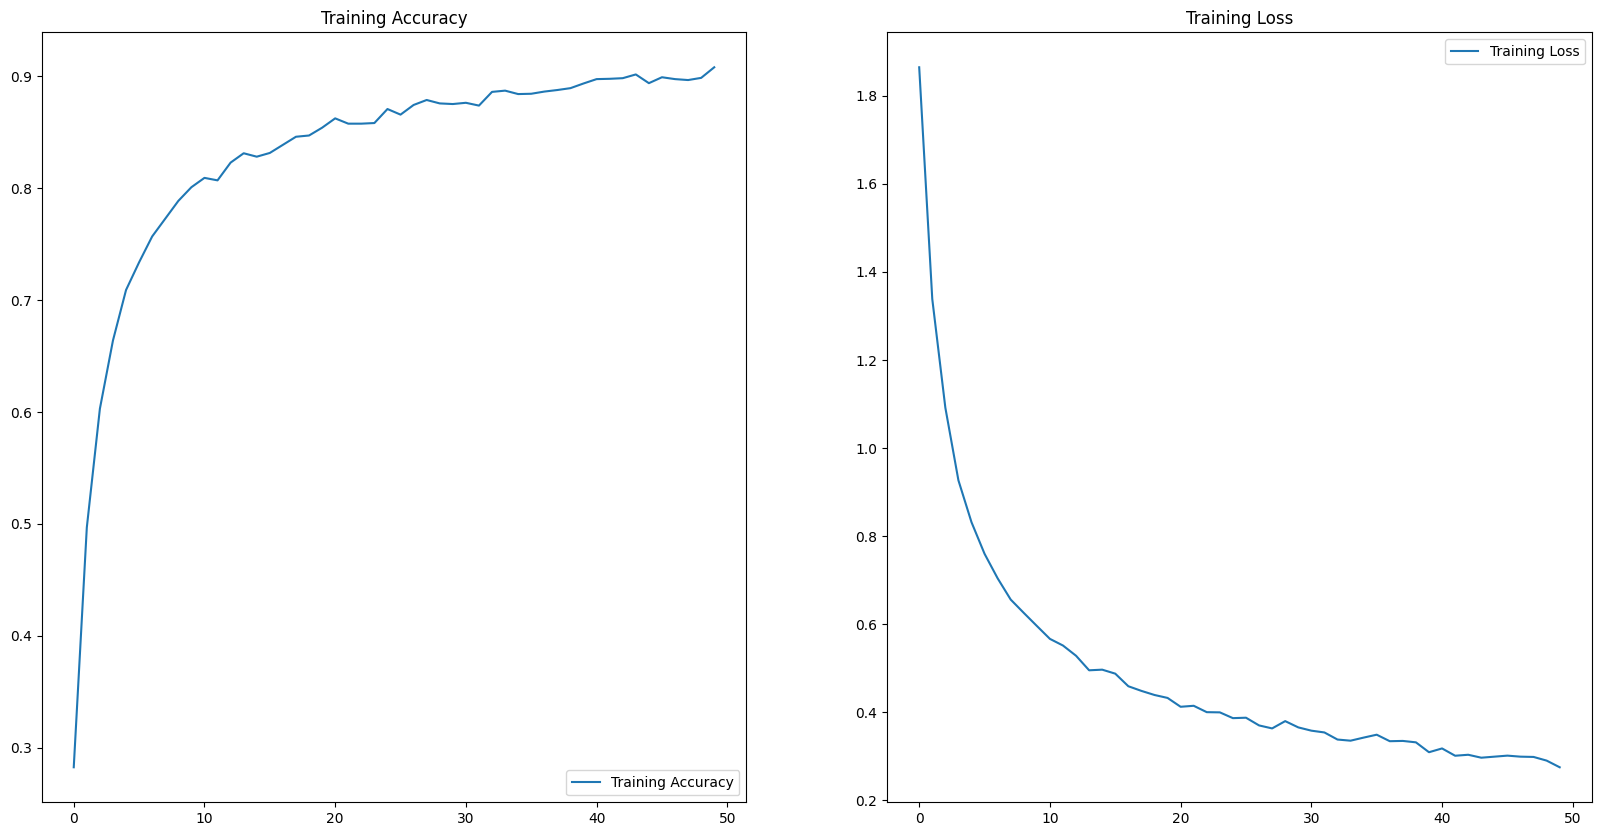

In [ ]:
# plotting training accuracy & loss.
acc = hist.history['accuracy']
loss = hist.history['loss']
epochs_range = range(len(hist.epoch))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
# saving the model
model.save_weights("CottonPlantDiseaseClassifier.h5")

# Fine-Tuning Model

In [ ]:
# fine tuning
'''
trying to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is,
the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images
'''
base_model.trainable = True

# check number of layers in base model
print("Number of layers in the base model: ", len(base_model.layers))

# fine tuning top layers
fine_tune_at = 100

# freeze layers before the *fine_tune_at* layer
for l in base_model.layers[:fine_tune_at]:
    l.trainable = False

Number of layers in the base model:  154


In [ ]:
# re-compile the model
'''using a lower learning rate to avoid overfitting'''
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# re-training the model
hist_finetune = model.fit(ds_train
          , epochs = 50
          , batch_size=BATCH_SIZE
          ,shuffle=True
          ,verbose=0
          ,callbacks=[TqdmCallback(verbose=0),earlyStopping])

0epoch [00:00, ?epoch/s]

In [ ]:
acc_finetuned = '{:.2%}'.format(hist_finetune.history['accuracy'][-1])
print(f"After finetuning our model has achieved an accuracy of  {acc_finetuned} in {len(hist_finetune.epoch)} epoch(s)")

After finetuning our model has achieved an accuracy of  98.94% in 37 epoch(s)


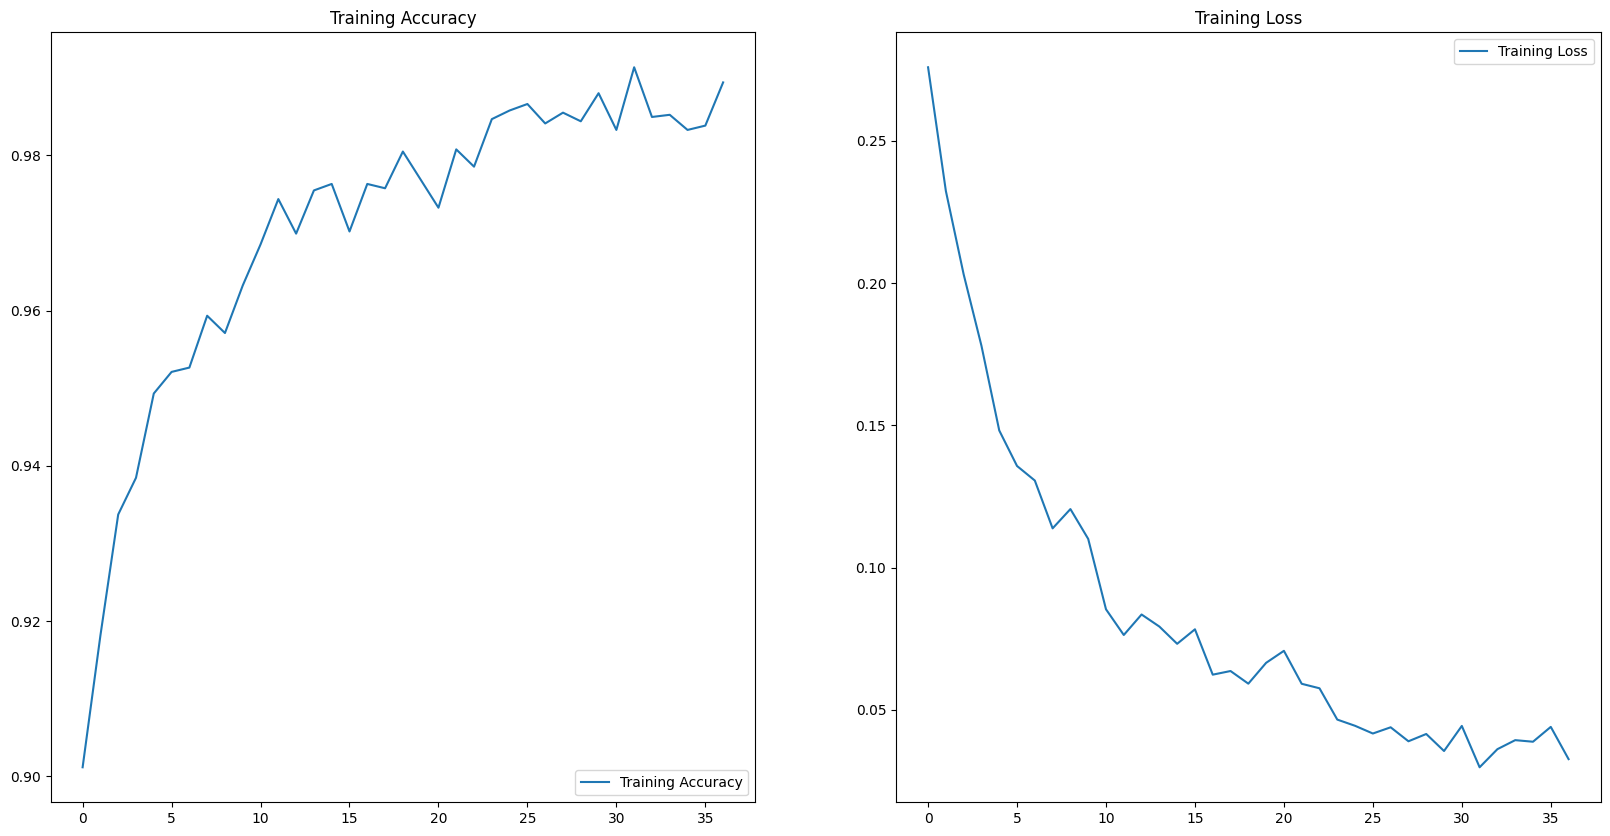

In [ ]:
# plotting finetuned training accuracy & loss.
acc = hist_finetune.history['accuracy']
loss = hist_finetune.history['loss']
epochs_range = range(len(hist_finetune.epoch))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
# saving the model
model.save_weights("CottonPlantDiseaseClassifier_finetuned.h5")

# Making Prediction

In [ ]:
# pre-processing the unseen image
image_path = "/content/drive/MyDrive/Cotton Leaf Disease/test/Army worm/Copy of Copy of 24.jpg"
img = Image.open(image_path)
expd_class_name = image_path.split('/')[6]
unseen_img = keras.preprocessing.image.load_img(image_path,target_size=(IMG_SIZE, IMG_SIZE))
input_arr = tf.keras.preprocessing.image.img_to_array(unseen_img)
# convert single image to a batch
input_arr = np.array([input_arr])
input_arr = input_arr.astype('float32') / 255.

In [ ]:
# making prediction
pred = model.predict(input_arr)
# predicting class
pred_class = np.argmax(pred, axis=1)
# predicting class name
image_data.class_names.reverse()
for c in enumerate(image_data.class_names):
    if c[0] == pred_class[0]:
        print(f"Predicted Class Name: {c[1]}")
        pred_class_name = c[1]

1/1 [==============================] - 0s 44ms/step
Predicted Class Name: Army worm


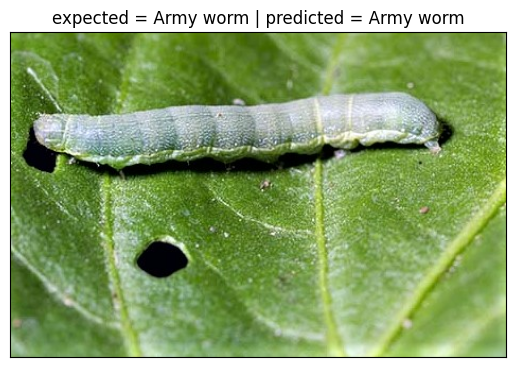

In [ ]:
# plot the image
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('expected = '+expd_class_name+' | predicted = '+pred_class_name)
plt.show()

In [ ]:
test_data.options

<bound method DatasetV2.options of <_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>

In [ ]:
y_pred = model.predict(test_data)
y_pred

1/1 [==============================] - 12s 12s/step


array([[2.26353450e-07, 9.99999344e-01, 4.63461269e-09, 1.07426761e-08,
        2.44107460e-11, 3.99015335e-07],
       [8.31138532e-05, 1.13094121e-08, 2.55868576e-06, 9.99847174e-01,
        2.30291039e-06, 6.49706999e-05],
       [1.89173989e-11, 2.63509516e-08, 2.56840664e-13, 1.31702052e-10,
        9.99999821e-01, 1.08276438e-07],
       [6.04154282e-09, 9.99999940e-01, 1.84762716e-09, 2.77316339e-08,
        5.21848569e-13, 1.70351147e-08],
       [4.51571580e-09, 9.99999940e-01, 3.72948547e-12, 1.69073325e-10,
        1.73530515e-12, 1.52014712e-09],
       [6.80952295e-10, 5.39343535e-11, 9.82986914e-10, 1.30947431e-09,
        9.99999821e-01, 1.09636801e-07],
       [1.00284838e-03, 7.02965437e-08, 2.26264619e-05, 9.98966455e-01,
        4.22453716e-08, 7.90951981e-06],
       [1.01116177e-06, 2.26896773e-07, 9.99981225e-01, 1.70394188e-07,
        9.84771570e-11, 1.73721128e-05],
       [5.47697276e-10, 3.60150807e-08, 4.50239542e-12, 7.92245647e-09,
        9.99999940e-01, 

In [ ]:
# Selecting the category based on maximum probability
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([1, 3, 4, 1, 1, 4, 3, 2, 4, 5, 2, 3, 5, 3, 2, 0, 2, 5, 0, 5, 0, 0,
       5, 1, 2, 4, 3, 1, 4, 0])

In [ ]:
test_data.file_paths

['/content/drive/MyDrive/Cotton Leaf Disease/test/Aphids/Copy of Copy of 21.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Bacterial Blight/Copy of Copy of 22.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Aphids/Copy of Copy of 22.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Army worm/Copy of Copy of 25.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Healthy/Copy of Copy of 23.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Target spot/Copy of Copy of 24.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Healthy/Copy of Copy of 22.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Healthy/Copy of Copy of 25.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Army worm/Copy of Copy of 22.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Army worm/Copy of Copy of 24.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Powdery Mildew/Copy of Copy of 21.jpg',
 '/content/drive/MyDrive/Cotton Leaf Disease/test/Powdery Milde

In [ ]:
d = {'Aphids':0, 'Army worm':1, 'Bacterial Blight':2, 'Healthy':3, 'Powdery Mildew':4, 'Target spot':5}
y_test=[d[i.split('/')[6]] for i in test_data.file_paths]
y_test

[2,
 3,
 0,
 4,
 0,
 3,
 1,
 4,
 5,
 2,
 2,
 5,
 3,
 4,
 1,
 4,
 1,
 4,
 5,
 0,
 5,
 5,
 2,
 1,
 3,
 2,
 0,
 3,
 0,
 1]

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# y_test = label_encoder.fit_transform(y_test)
# y_test

array([0, 2, 0, 1, 3, 5, 3, 3, 1, 1, 4, 4, 2, 2, 5, 2, 5, 0, 1, 0, 5, 5,
       3, 3, 1, 4, 4, 4, 0, 2])

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
acc

0.1